In [109]:
import numpy as np                                      
import matplotlib.pyplot as plt                         
import matplotlib.patches as patches
import seaborn as sns
import scipy.signal as signal 
from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import pandas as pd
from scipy.signal import welch

In [110]:
# Define our filter variables
fs = 512                      # Hz; sampling rate
dt = 1000. / fs                 # ms; time between samples
sdt = dt#np.round(dt).astype(int); # rounded dt so that we can index samples
hp = 1                        # Hz; our low cut for our bandpass
lp = 24.                        # Hz; our high cut for our bandpass
num_taps = 31                   # Number of taps/coefficients of FIR filter

# Create our filter coefficients
# Note: by defining 'fs' we don't divide our windows by the Nyquist
# Note: for FIR filters, a is always 1
b = signal.firwin(numtaps=num_taps, cutoff=[hp, lp], pass_zero='bandpass', fs=fs)
a = 1

# Define ERP-related variables
epoch_start = 0    # ms
epoch_end = 800    # ms
baseline_start = 0 # ms
baseline_end = 100 # ms
erp_start = 100    # ms
erp_end = 600      # ms

# Let's translate these from time into index space to save time later
e_s = np.round(epoch_start / sdt).astype(int)     # epoch start
e_e = np.round(epoch_end / sdt).astype(int)       # epoch end
bl_s = np.round(baseline_start / sdt).astype(int) # baseline start
bl_e = np.round(baseline_end / sdt).astype(int)   # baseline end
erp_s = np.round(erp_start / sdt).astype(int)     # ERP component window start
erp_e = np.round(erp_end / sdt).astype(int)       # ERP component window end

In [111]:
import util as myUtil
def load_file_from_bi2015a(filename):
    headerNames = pd.read_csv('./datasets/bi2015a/Header.csv', header=None)
    headerNames = np.array(headerNames.iloc[0]).flatten()
    if not Path(filename).exists():
        raise ValueError("File does not exist   " + filename)
    df = pd.read_csv(filename, header=None)
    df.columns = headerNames
    del headerNames
    #timestamps = df['Time'].values
    sample_rate = 512
    x = df.iloc[:, 1:-2].values
    df = df.iloc[:, -2:]
    df['y'] = 0
    df.loc[df['Trigger'] == 1, 'y'] = -1
    df.loc[df['Target'] == 1, 'y'] = 1
    y = df.y.values
    del df
    # x = myUtil.resample_x(x, rate=sample_rate)
    # y = myUtil.resample_y(y, rate=sample_rate)
    return x, y

In [112]:
# load the data
subject = range(2,5)
session = [1, 2, 3]
X_train = None
y_train = np.array([])
for i in subject:
    for j in session:
        x, y = load_file_from_bi2015a(f'./datasets/bi2015a/subject_{i:02}_session_{j:02}.csv')
        x, y = myUtil.epoch_wrt_event(x, y, e_s, e_e)
        X_train = np.concatenate((X_train, x)) if X_train is not None else x
        y_train = np.concatenate((y_train, y))

print(X_train.shape, y_train.shape)

linesI_no_nan = np.where(np.isnan(X_train).any(axis=1).any(axis=1) == False)[0]
X_train = X_train[linesI_no_nan]
y_train = y_train[linesI_no_nan]

print(X_train.shape, y_train.shape)

(3996, 410, 32) (3996,)
(3996, 410, 32) (3996,)


In [113]:
# explore the data

X_train = X_train[np.where(np.isnan(X_train).any(axis=1).any(axis=1) == False)[0], :, :]
#np.where(np.isnan(X_train).any(axis=1).any(axis=1) == False)[0]

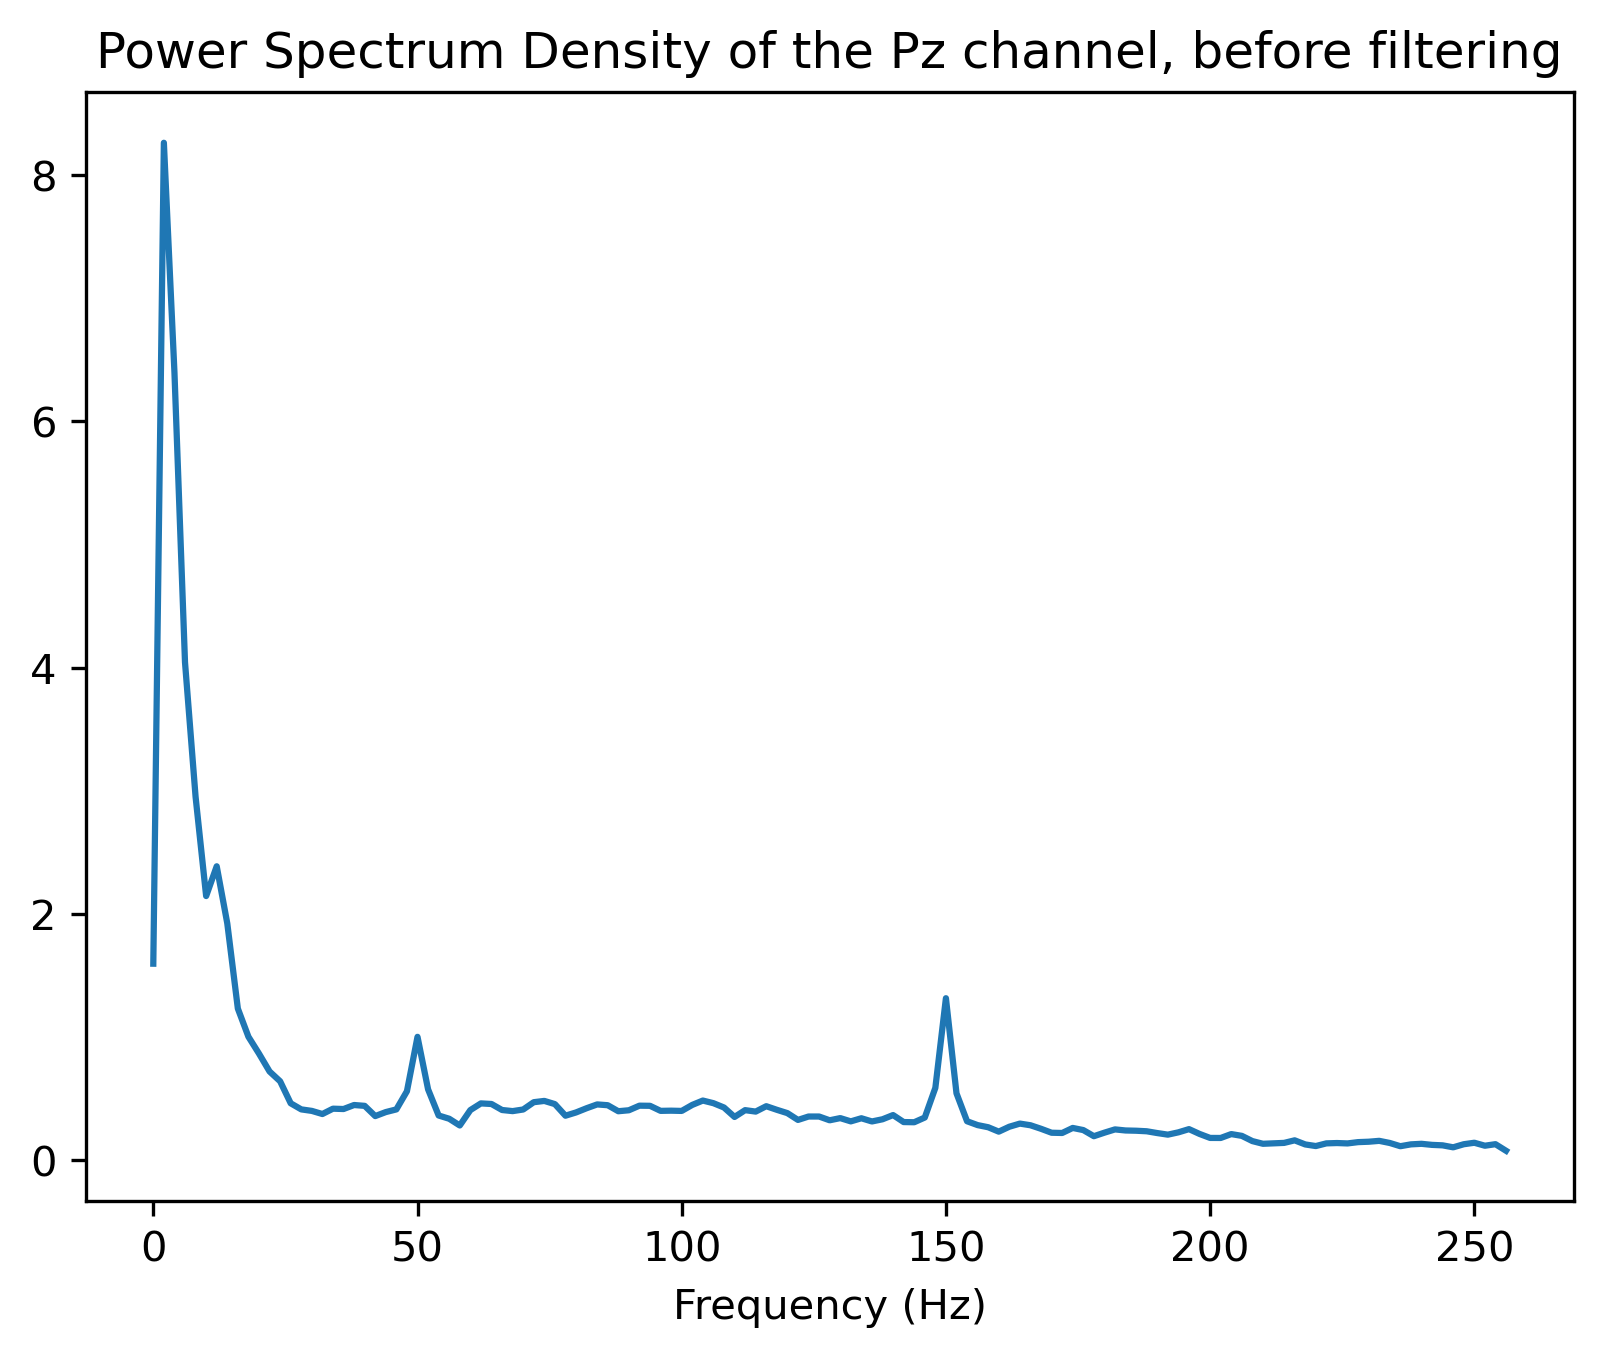

In [114]:
# show power spectrum density of the data
f = None
amp = None
for i in range(0, 100):
    x = X_train[i, :, 22]
    f_tmp, amp_tmp = welch(x, fs=512)
    f = f_tmp if f is None else f
    amp = amp_tmp if amp is None else amp + amp_tmp
amp = amp / 100
plt.plot(f, amp)
plt.title('Power Spectrum Density of the Pz channel, before filtering')
plt.gcf().set_dpi(300)
plt.gca().set_xlabel('Frequency (Hz)')
plt.show()

In [115]:
def preprocess_mean(x):
    for i in range(x.shape[0]):
        # correct DC offset of signal
        x[i] = x[i] - np.mean(x[i], axis=0)

preprocess_mean(X_train)

(array([240., 157., 193.,   3.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   8.,
         51.,   9.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  36.69268293,  279.30176829,  521.91085366,  764.51993902,
        1007.12902439, 1249.73810976, 1492.34719512, 1734.95628049,
        1977.56536585, 2220.17445122, 2462.78353659, 2705.39262195,
        2948.00170732, 3190.61079268, 3433.21987805, 3675.82896341,
        3918.43804878, 4161.04713415, 4403.65621951, 4646.26530488,
        4888.87439024, 5131.48347561, 5374.09256098, 5616.70164634,
        5859.31073171, 6101.91981707, 6344.52890244, 6587.1379878 ,
        6829.74707317, 7072.35615854, 7314.9652439 , 7557.57432927,
        7800.18341463, 8042.7925    , 8285.40158537, 8528.01067073,
        8770.6197561 , 9013.22884146, 9255.83792683, 9498.4470122 ,
        9741.05609756]),
 <BarContainer object

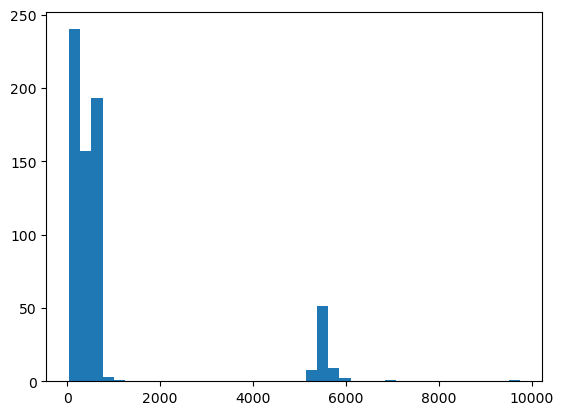

In [116]:
# find the abnormal peak in any channel, before filtering
x = X_train[:, :, :]
max_amps = []
min_amps = []
for i in range(0, x.shape[0]):
    if y_train[i] == 1:
        max_amps.append(np.max(x[i]))
        min_amps.append(np.min(x[i]))

plt.hist(max_amps, bins=40)

In [117]:
# pre-processing, inplace
def preprocess(x):
    for i in range(x.shape[0]):
        # correct DC offset of signal
        #x[i] = x[i] - np.mean(x[i], axis=0)
        # bandpass filter
        x[i] = signal.filtfilt(b, a, x[i], axis=0)
        # baseline correction
        #x[i] = x[i] - np.mean(x[i][bl_s:bl_e], axis=0)

preprocess(X_train)

In [118]:
np.where(np.isnan(X_train).any(axis=1).any(axis=1))[0]

array([], dtype=int64)

78.04689358030654


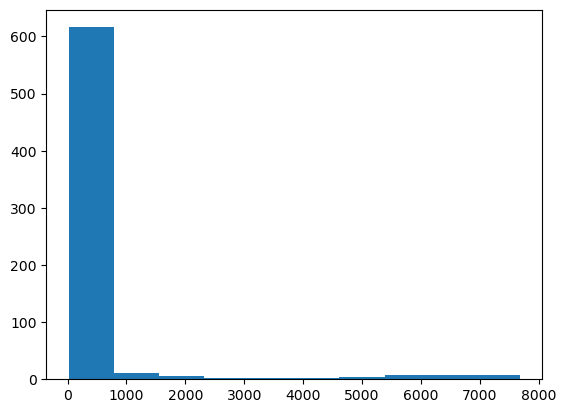

In [119]:
# find the abnormal peak in any channel, after filtering
x = X_train[:, :, :]
max_amps = []
min_amps = []
for i in range(0, x.shape[0]):
    if y_train[i] == 1:
        max_amps.append(np.max(x[i]))
        min_amps.append(np.min(x[i]))

plt.hist(max_amps, bins=10)
print(np.median(max_amps))

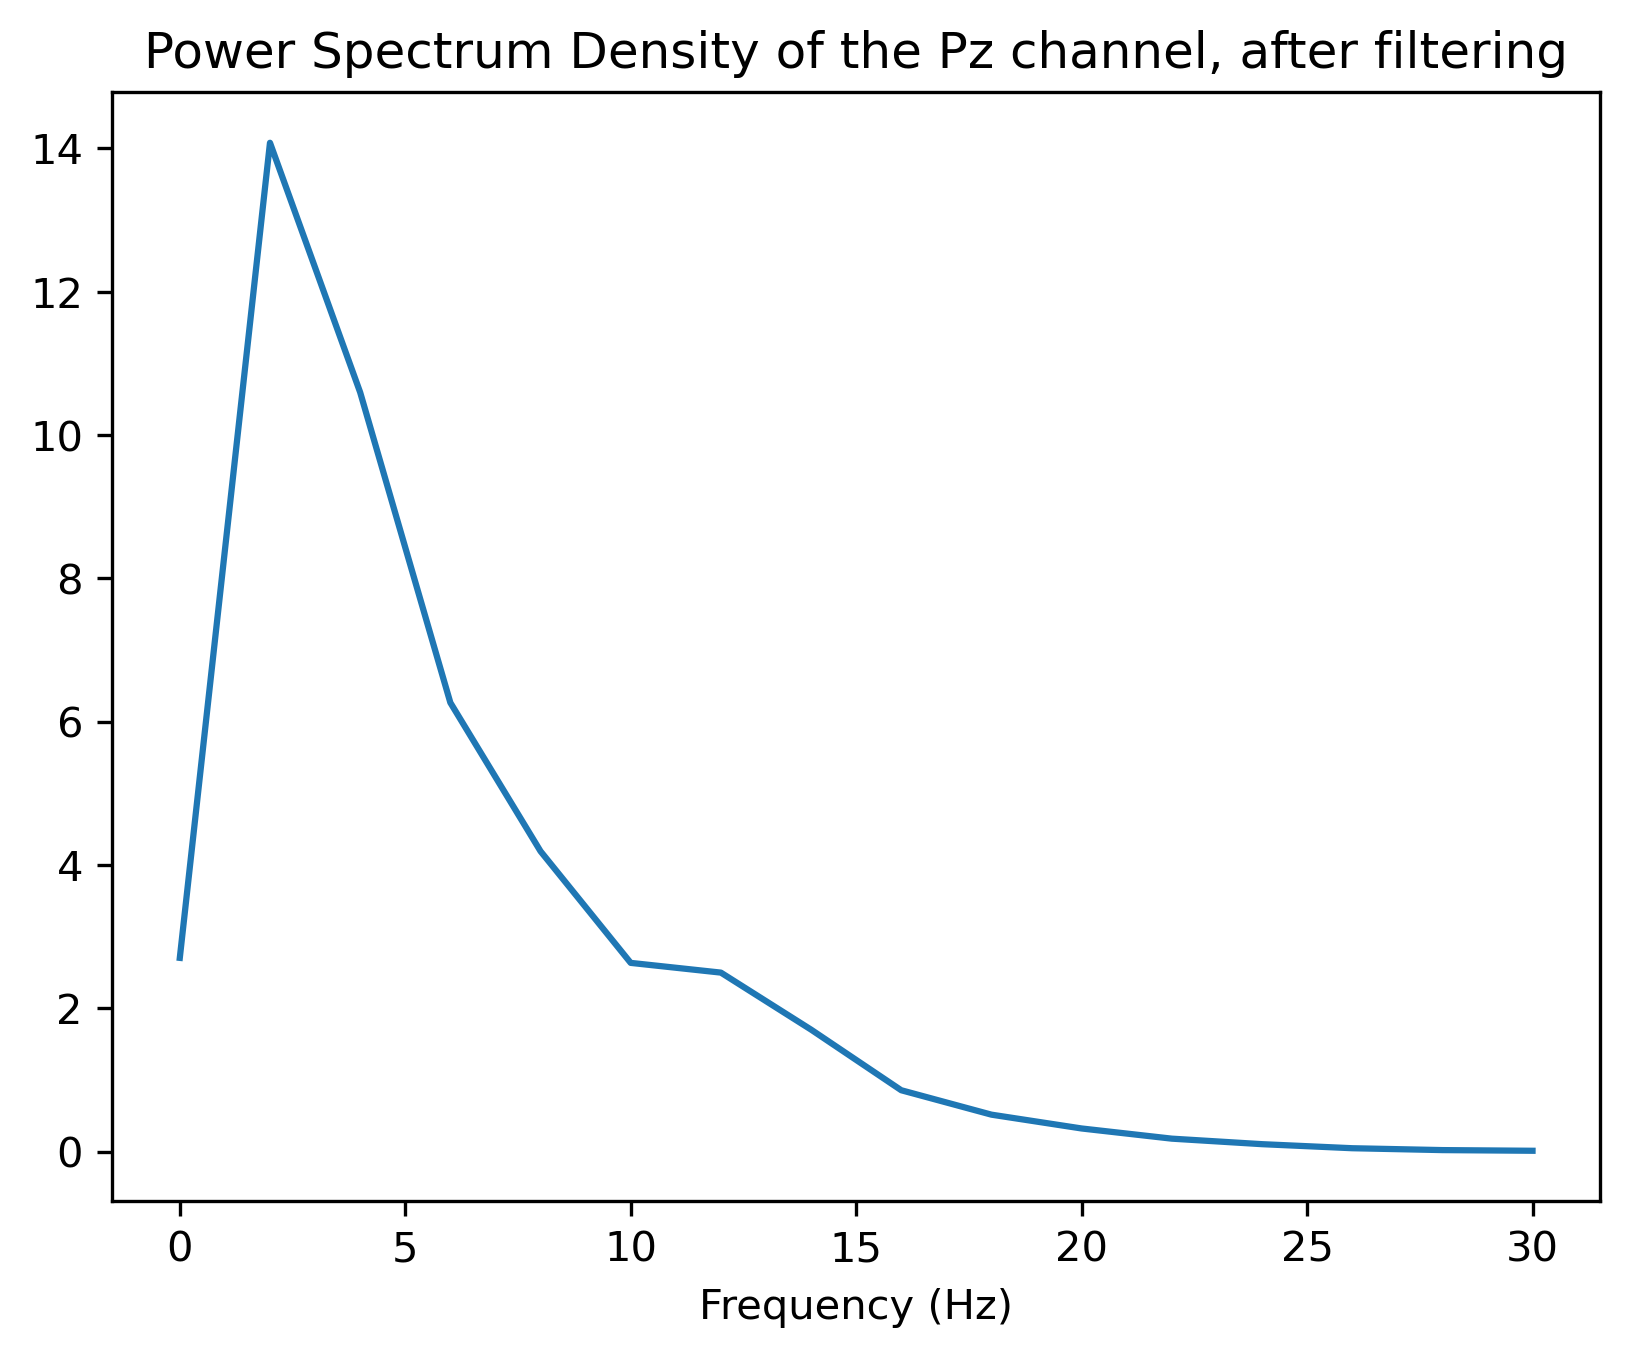

In [120]:
# show power spectrum density of the data
f = None
amp = None
for i in range(0, 100):
    x = X_train[i, :, 22]
    f_tmp, amp_tmp = welch(x, fs=512)
    f = f_tmp if f is None else f
    amp = amp_tmp if amp is None else amp + amp_tmp
amp = amp / 100
f = f[:16]
amp = amp[:16]
plt.plot(f, amp)
plt.title('Power Spectrum Density of the Pz channel, after filtering')
plt.gcf().set_dpi(300)
plt.gca().set_xlabel('Frequency (Hz)')
plt.show()

In [121]:
#plt.plot(X_train[0, :, 22])
print(X_train[0].shape)
np.nan_to_num(x=X_train, copy=False);

(410, 32)


We have 666 target trials
We have 3330 non-target trials
(410, 32) (410, 32)
-4.995131529154931 4.504659386809923


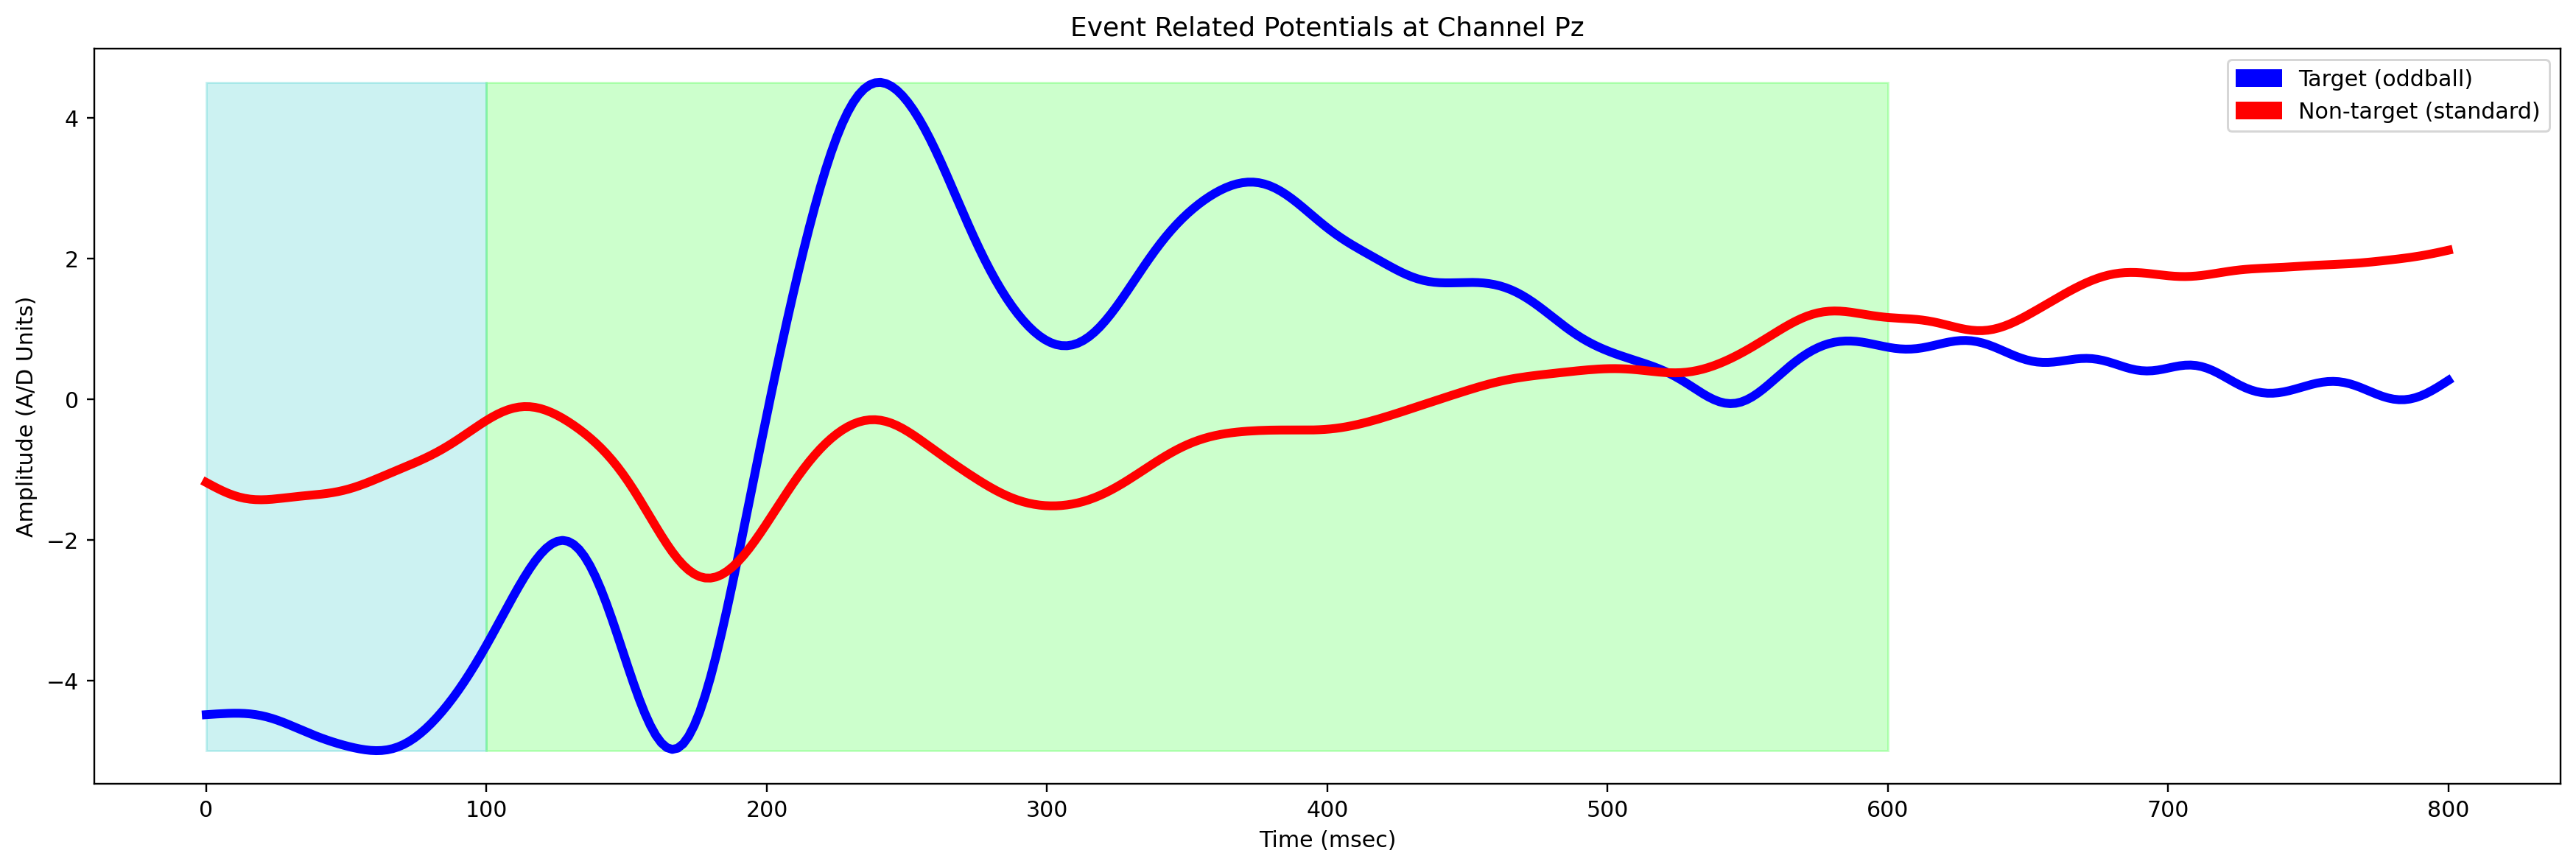

In [122]:
train_data = X_train
train_labels = y_train

# Seperate target and non-target for plotting
tar     = train_data[np.where(train_labels == 1)[0], :, :]
non_tar = train_data[np.where(train_labels == -1)[0], :, :]

print(f'We have {tar.shape[0]} target trials')
print(f'We have {non_tar.shape[0]} non-target trials')
# print(tar.shape, non_tar.shape)
# print(tar[0, :, 22])

# We'll take the average of all trials to create an averaged ERP
#tar_avg     = np.mean(tar[1000:1001], axis=0)
tar_avg = np.mean(tar, axis=0)
non_tar_avg = np.mean(non_tar, axis=0)
print(tar_avg.shape, non_tar_avg.shape)
# print(tar_avg[:, 22], non_tar_avg[:, 22])

# Define channel of interest and create an array of time points
chan = 'Pz' # let's plot Pz
#ch = np.where(channels == chan)[0][0]
ch = 22
times = np.linspace(epoch_start, epoch_end, train_data.shape[1])

# Initialize plot and calculate min and max y value
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
min_y = min(np.min(tar_avg[:,ch]), np.min(non_tar_avg[:,ch]))
max_y = max(np.max(tar_avg[:,ch]), np.max(non_tar_avg[:,ch]))
print(min_y, max_y)
# min_y = -5
# max_y = 5

# Plot x and y axes
# plt.plot([np.min(times), np.max(times)], [0, 0], color='k');  # x-axis
# plt.plot([0, 0], [min_y, max_y], color='k');                  # y-axis

# Plot our averaged ERPs
plt.plot(times, tar_avg[:, ch], 'b', linewidth=4)
plt.plot(times, non_tar_avg[:, ch], 'r', linewidth=4)

# Highlight the baseline window and window of interest of our ERP
baseline = patches.Rectangle([baseline_start, min_y], baseline_end, np.abs(min_y)+max_y, 
                             color='c', alpha=0.2)
erp_win = patches.Rectangle([erp_start, min_y], erp_end-erp_start, np.abs(min_y)+max_y, 
                             color='lime', alpha=0.2)

# Add our baseline and window of interest highlights
ax.add_patch(baseline)
ax.add_patch(erp_win)

# Manually create legends since patches will corrupt default handles
legend_ = [patches.Patch(color='b', label = 'Target (oddball)'),
           patches.Patch(color='r', label = 'Non-target (standard)')]

# Finalize plot and set a high DPI for a crisp, hi-res figure
plt.xlabel('Time (msec)');
plt.ylabel('Amplitude (A/D Units)');
plt.legend(handles=legend_, loc='upper right');
plt.title(f'Event Related Potentials at Channel {chan}');
fig.set_dpi(216);
plt.show();

In [123]:
# pre-processing, inplace
def preprocess(x):
    for i in range(x.shape[0]):
        # correct DC offset of signal
        x[i] = x[i] - np.mean(x[i], axis=0)
        # bandpass filter
        #x[i] = signal.filtfilt(b, a, x[i], axis=0)
        # baseline correction
        #x[i] = x[i] - np.mean(x[i][bl_s:bl_e], axis=0)

preprocess(X_train)

In [124]:
# downsample

num_points = 12; # we will divide our window into num_points means
# Define a simple windowed means function
def wm(x, start, end, num_points):
    num_trials = x.shape[0] # assumes first dem is numb observations
    w = np.round((start+end)/num_points).astype(int)
    y = np.zeros((num_points, x.shape[-1], num_trials)) # assumes num chans as last dimension
    for i in range(0, num_points):
        s = start + (w * i)
        e = end   + (w * i)
        y[i, :, :] = np.mean(x[:, s:e, :], 1).T
    return y

#X_train = wm(X_train, erp_s, erp_e, num_points)
#X_test = wm(X_test, erp_s, erp_e, num_points)

In [125]:
# Since our X is 3D, we must flatten our data. We will then transpose it for sklearn
#X_train = X_train.reshape(-1, X_train.shape[-1]).T
#X_test = X_test.reshape(-1, X_test.shape[-1]).T

# Let's print out the new shape
print('X_train shape is now: ' + str(X_train.shape))
#print('X_test  shape is now: ' + str(X_test.shape))

X_train shape is now: (3996, 410, 32)
